(C) Copyright 2024 Federico Gallina, Matteo Bruschi, Barbara Fresch

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Mission  **$\beta$**:
# The Density Matrix Formalism
#
<div>
<img src="Images\Mission beta\Mission beta.jpg" width="500"/>
</div>

In this notebook, is divided in the following Sections:
1) Density matrix
2) Liouville-von Neumann equation
3) Quantum Master Equation (QME)
4) Lindblad equation
5) Vectorization/Choi-Jamiolkowski isomorphism

Now, we import some libraries

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from qutip import sigmax, sigmaz, sigmay, tensor, identity
from qutip import Bloch, Qobj, basis, mesolve, sesolve
from qutip.stochastic import ssesolve
from IPython.display import Image, display, Math

define a function for matrix visualization in LaTeX

In [2]:
def array_to_latex(array, real = False, array_name = None):
    array = array.real if real else array
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    if array_name != None:
        display(Math(array_name+r' = \begin{bmatrix}'+matrix+r'\end{bmatrix}'))
    else:
        display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

define operators $\sigma^+$ and $\sigma^-$ (attention: qutip definition of these operators is the inverse of our convention)

In [3]:
sigmap = (sigmax() - 1.j * sigmay()) / 2
sigmam = (sigmax() + 1.j * sigmay()) / 2

## 1) Density matrix

The most general description of a system's quantum state is given by its density matrix:

$$ \rho(t) = \sum_{k} p_{k} | \psi_{k}(t)\rangle \langle \psi_{k}(t) | $$

where $p_{k}$ is the probability to find the system in $| \psi_{k}(t) \rangle $.

If $p_{k} = \delta_{kk'} $, the system is in the pure state $| \psi_{k'}(t) \rangle $, otherwise the system is said to be in a mixed state.

The purity of a density matrix state in an Hilbert space $\mathscr{H}$ is evaluated as
$$
\text{Purity} = \text{Tr}\{ \rho^2 \}
$$
and is bounded as
$$
\frac{1}{\text{dim} ( \mathscr{H} )} \leq \text{Tr}\{ \rho^2 \} \leq 1
$$

Given an orthonormal basis, the density matrix can be written as:

$$ \rho(t) = \sum_{n,m} \rho_{nm}(t) | n \rangle \langle m | $$

where the diagonal elements $\rho_{nn}(t) = |c_{n}(t)|^{2} = |c_{n}(t_{0})|^2$ are known as populations (probability that the system is in a certain state), while the off-diagonal elements $\rho_{nm}(t) = c_{n}(t) c_{m}^{*}(t)$ are known as coherences (phase relation between different states $\rightarrow$ quantum superposition). 

The following relation must be satisfied:

$$ |\rho_{nm}|^2 \leq \rho_{nn} \rho_{mm} $$

Properties of the density matrix:
- hermitian $\rho = \rho^{\dagger}$
- unitary trace $\text{Tr}\{ \rho \} = 1$
- positive semi-definite: $p_{k} \geq 0$

In [4]:
psi_a = np.array([1,0])
psi_b = np.array([0,1])
psi_ab = np.array([1,1]) / np.sqrt(2)

rho_1 = np.outer(psi_a, np.conj(psi_a)); array_to_latex(rho_1, array_name=r'\rho_1')
rho_2 = np.outer(psi_ab, np.conj(psi_ab)); array_to_latex(rho_2, array_name=r'\rho_2') # Now you know what numerical accuracy is...
rho_3 = 0.5 * np.outer(psi_a, np.conj(psi_a)) + 0.5 * np.outer(psi_b, np.conj(psi_b)); array_to_latex(rho_3, array_name=r'\rho_3')

purity_1 = np.trace(rho_1 @ rho_1); print('Purity_1 = ', purity_1)
purity_2 = np.trace(rho_2 @ rho_2); print('Purity_2 = ', purity_2)
purity_3 = np.trace(rho_3 @ rho_3); print('Purity_3 = ', purity_3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Purity_1 =  1
Purity_2 =  0.9999999999999996
Purity_3 =  0.5


Note that the form of the density matrix does not involve any quantum (coherent) superposition between the states $| \psi_{k}(t) \rangle $ that compose it.

For example, $\frac{1}{2} \left( | 0 \rangle \langle 0 | + | 1 \rangle \langle 1 | \right)$ is profoundly different from $\frac{1}{\sqrt{2}} \left( | 0 \rangle + | 1 \rangle \right) \to \frac{1}{2} \left( | 0 \rangle \langle 0 | + | 1 \rangle \langle 1 | + | 0 \rangle \langle 1 | + | 1 \rangle \langle 0 | \right)$.

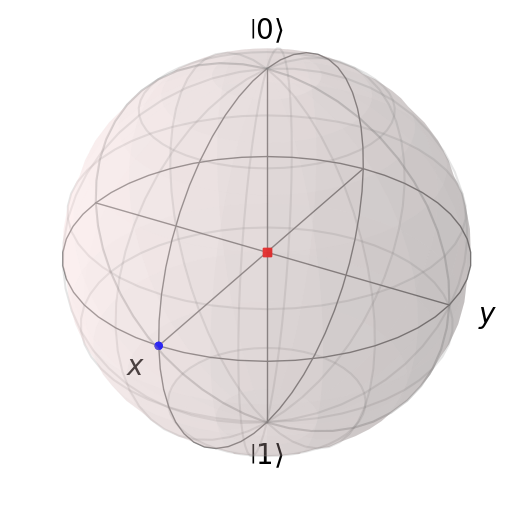

In [6]:
sphere = Bloch()
sphere.add_points([np.trace(rho_2 @ sigmax().full()), np.trace(rho_2 @ sigmay().full()), np.trace(rho_2 @ sigmaz().full())]);
sphere.add_points([np.trace(rho_3 @ sigmax().full()), np.trace(rho_3 @ sigmay().full()), np.trace(rho_3 @ sigmaz().full())]);
sphere.show();

## Density matrix: Reduced vs Statistical

<div>
<img src="Images\Mission beta\density matrix 1.png"/>
</div>

<div>
<img src="Images\Mission beta\density matrix 2.png"/>
</div>


## Liouville-von Neumann Equation

The density matrix evolves according to the Liouville-von Neumann equation:

$$ \frac{d}{dt} \rho(t) = - \frac{i}{\hbar} [H, \rho(t)] $$

where $[A, B] = AB - BA$ is the commutator. This equation can be derived directly from the Schrödinger equation and it represents a quantum analogue of the (classical) Liouville equation.

Notice that, for a pure state, solving the Liouville-von Neumann equation is analogous to solving the Schrödinger equation but it results more computationally demanding!

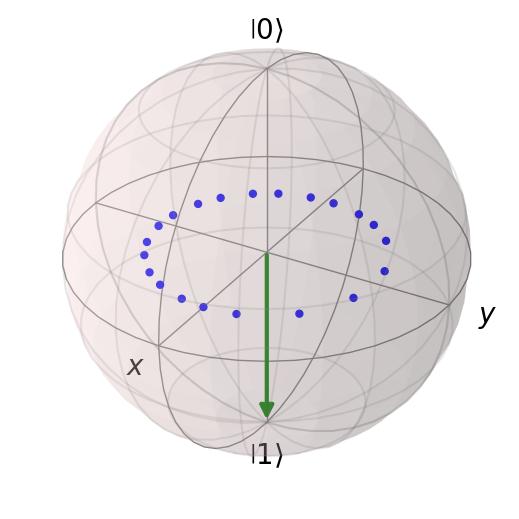

In [21]:
H = np.array([[0, 0],
              [0, 1]])
rho = np.array([[1, 0.6],
                [0.6, 1]])/2
dt = 0.5; t_list = np.arange(0, 10 + dt, dt)

sphere = Bloch()
result = mesolve(Qobj(H),
                 Qobj(rho) if Qobj(rho).isherm else False,
                 t_list,
                 e_ops=[sigmax(), sigmay(), sigmaz()])
sx, sy, sz = result.expect[0], result.expect[1], result.expect[2]
sphere.add_points([sx, sy, sz]); sphere.add_vectors([0., 0., -1.])
sphere.show()

## Quantum Master Equation (QME)

The Quantum Master Equation is an equation of motion for the density matrix:

$$ \frac{d}{dt} \rho(t) = -\frac{i}{\hbar} \left[ H, \rho(t) \right] + \mathcal{D}[\rho(t)]$$

where the first term represents the (coherent) unitary evolution due to the system Hamiltonian, while the second term is the dissipator which rules the (incoherent) relaxation and decoherence processes in the system due to the interaction with an environment (e.g., vibrations, phonons, solvent). 

There are several approaches which allows to define a form for the dissipator $\mathcal{D}[\cdot]$. These can be distinguished into:

- axiomatic approach: the QME is assumed a priori (e.g., from mathematical properties)
- constructive approach: the QME is derived from a microscopic model

## Lindblad equation

Lindblad equation is a linear and Markovian QME deriving from an axiomatic approach:

$$ \frac{d}{dt} \rho(t) = -\frac{i}{\hbar} \left[ H, \rho(t) \right] + \sum_{k} \gamma_{k} \left( L_{k} \rho(t) L_{k}^{\dagger} - \frac{1}{2} \left\{  L_{k}^{\dagger} L_{k}, \rho(t) \right\} \right)$$

where $[A, B] = AB - BA$ is the commutator, $\{ A, B \} = AB + BA$ is the anticommutator, while $L_{k}$ are the Lindblad operators (or jump operators).

The Lindblad equation ensures two important properties of the evolution (dynamical map):

- trace-preserving
- completely positive

## Vectorization/Choi-Jamiolkowski isomorphism

The Choi-Jamiolkowski isomorphism establishes a mapping between:

$$
\begin{matrix}
\text{Hilbert} & & \text{Liouville}\\ 
ABC & \rightarrow & (C^{T} \otimes A) \text{vec}(B)
\end{matrix}
$$

In this way, the Lindblad equation can be written as:

$$\frac{d}{dt} \text{vec}\{\rho(t)\} = \mathcal{L} \text{vec}\{\rho(t)\}$$

where the Liouvillian superoperator is:

$$\mathcal{L} = -\frac{i}{\hbar} (I \otimes H - H^T \otimes I ) + \sum_{k} \gamma_{k} \left( L_{k}^{*} \otimes L_{k} - \frac{1}{2} I \otimes L_{k}^{\dagger} L_{k} - \frac{1}{2} (L_{k}^{\dagger}L_{k})^{T} \otimes I \right)$$

and

$$
\rho(t) = 
\begin{bmatrix}
a & b \\
c & d \\
\end{bmatrix}
\qquad
\text{vec}\{ \rho(t) \} = 
\begin{bmatrix}
a \\
b \\
c \\
d
\end{bmatrix}
$$

Now, we define a generic function for the creating the Liouvillian and another one for its time propagator.

In [7]:
def Liouvillian(H: np.ndarray,
                gamma_k: list,
                L_k: list):
    I = np.eye(H.shape[0])
    super_L = -1.j * (np.kron(I, H) - np.kron(H.T, I))
    for k in range(len(gamma_k)):
        super_L += gamma_k[k] * (np.kron(np.conj(L_k[k]), L_k[k]) - 0.5 * np.kron(I, np.conj(L_k[k]).T @ L_k[k]) - 0.5 * np.kron((np.conj(L_k[k]).T @ L_k[k]).T, I))
    return super_L

def Liouville_evo(rho, super_L, t_list):
    dt = t_list[1] - t_list[0]
    rho_vec = np.reshape(rho,(rho.size))
    rho_vec_list = np.zeros((rho.size, len(t_list)), dtype=complex)
    rho_vec_list[:,0] = rho_vec
    super_U = expm(super_L * dt)
    for i in range(1,len(t_list)):
        rho_vec_list[:,i] = super_U @ rho_vec_list[:,i-1]
    return rho_vec_list

Imagine we have a TLS described on the eigenbasis.
We have already seen that the Hamiltonian dynamics is a phase dynamics.

Here, we insert two relaxation processes now:

- the relaxation to the ground state, with a rate $\gamma_d$;
- an excitation to the excited state, with rate $\gamma_u$.

Look at the Liouvillian.

We start looking at **dissipation** processes.

In [34]:
gamma_d = 0.1; gamma_u = 0.0

H = np.array([[0, 0], [0, 1]])
array_to_latex(Liouvillian(H, [], []), array_name=r'\text{Only Hamiltonian}')

gamma_k = [gamma_d, gamma_u]
L_k = [sigmam.full(), sigmap.full()] 

super_L = Liouvillian(H, gamma_k, L_k)
array_to_latex(super_L, array_name=r'\text{With relaxations}')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

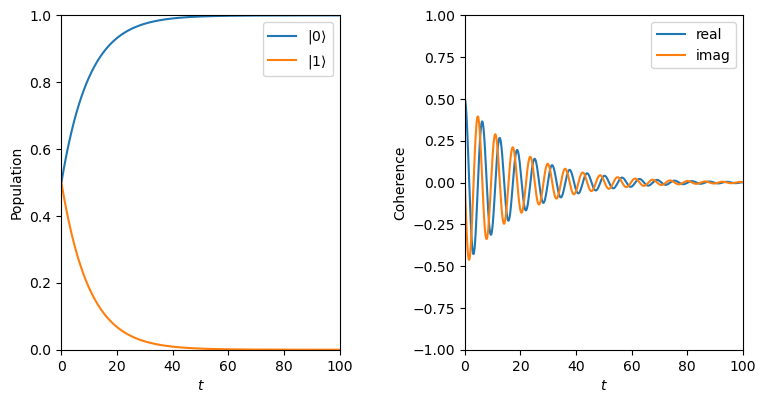

In [18]:
dt = 0.1; t_list = np.arange(0, 100 + dt, dt)

rho = np.array([[0.5, 0.5],
                [0.5, 0.5]], dtype=complex)
rho_vec_list = Liouville_evo(rho, super_L, t_list)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_list, np.real(rho_vec_list[0, :]), label=r'$| 0 \rangle$')
ax1.plot(t_list, np.real(rho_vec_list[3, :]), label=r'$| 1 \rangle$')
ax1.set_xlim(0, t_list[-1]); ax1.set_ylim(0, 1); ax1.set_xlabel(r'$t$'); ax1.set_ylabel('Population'); ax1.legend()
ax2.plot(t_list, np.real(rho_vec_list[1, :]), label='real')
ax2.plot(t_list, np.imag(rho_vec_list[1, :]), label='imag')
ax2.set_xlim(0, t_list[-1]); ax2.set_ylim(-1, 1); ax2.set_xlabel(r'$t$'); ax2.set_ylabel('Coherence'); ax2.legend()
fig.tight_layout(); fig.set_size_inches(8, 4); fig.set_dpi(100)

Let's visualize the dynamics of our TLS on the Bloch sphere.

In green, we show the precession axis dictated by the system Hamiltonian.

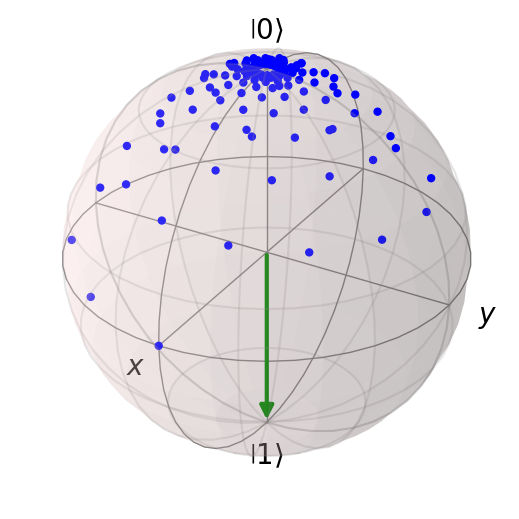

In [20]:
gamma_d = 0.1; gamma_u = 0.0; H = np.array([[0, 0],[0, 1]]); dt = 0.5; t_list = np.arange(0, 60 + dt, dt)

sphere = Bloch()
result = mesolve(Qobj(H),
                 (basis(2 ,0) + basis(2, 1)) / np.sqrt(2),
                 t_list,
                 c_ops=[np.sqrt(gamma_d) * sigmam, np.sqrt(gamma_u) * sigmap],
                 e_ops=[sigmax(), sigmay(), sigmaz()])
sx, sy, sz = result.expect[0], result.expect[1], result.expect[2]
sphere.add_points([sx, sy, sz]); sphere.add_vectors([0., 0., -1.])
sphere.show()

If you want to produce an animated gif run the following code.

In [145]:
import imageio.v2 as imageio
from os import listdir
from os.path import isfile, join
import shutil

In [ ]:
sphere = Bloch()
for i in range(len(sx)):
    sphere.clear()
    for j in range(i+1):
        sphere.add_points([sx[j], sy[j], sz[j]], alpha=np.exp((j-i)/15))
    sphere.add_vectors([0., 0., -1.])
    sphere.point_color ='b'; sphere.point_marker = 'o'; sphere.point_size = [25]
    sphere.make_sphere()
    sphere.save(name=r'temp_up_bloch\up_bloch_{}.png'.format(str(i).zfill(len(str(len(sx))))), dirc=r'temp_up_bloch')

filenames = [join('temp_up_bloch', filename) for filename in listdir('temp_up_bloch') if isfile(join('temp_up_bloch', filename))]
with imageio.get_writer('Images\Mission beta\movie_up_bloch.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
shutil.rmtree('temp_up_bloch')

<div>
<img src="Images\Mission beta\movie_up_bloch.gif" width="500"/>
</div>

Now, we look at another relaxation processes: **dephasing**.

In [43]:
# parameters
gamma_deph = 0.1

H = np.array([[0, 0],
              [0, 1]])

gamma_k = [gamma_deph]
L_k = [sigmaz().full()] 

super_L = Liouvillian(H, gamma_k, L_k)
array_to_latex(super_L, array_name=r'\mathcal{L}')

<IPython.core.display.Math object>

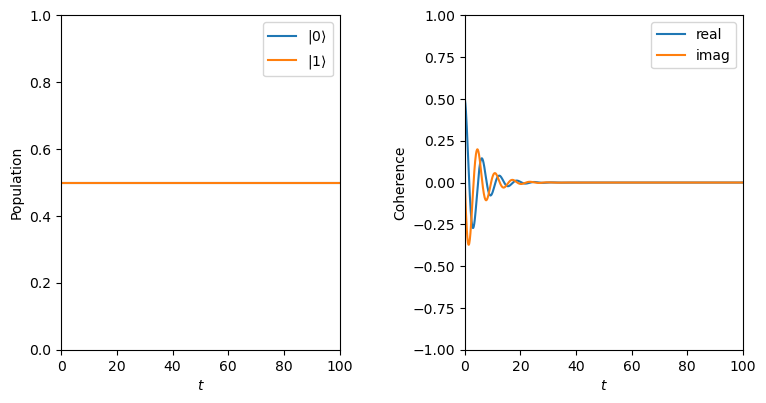

In [24]:
dt = 0.1; t_list = np.arange(0, 100 + dt, dt)

rho = np.array([[0.5, 0.5],
                [0.5, 0.5]], dtype=complex)
rho_vec_list = Liouville_evo(rho, super_L, t_list)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_list, np.real(rho_vec_list[0, :]), label=r'$| 0 \rangle$')
ax1.plot(t_list, np.real(rho_vec_list[3, :]), label=r'$| 1 \rangle$')
ax1.set_xlim(0, t_list[-1]); ax1.set_ylim(0, 1); ax1.set_xlabel(r'$t$'); ax1.set_ylabel('Population'); ax1.legend()
ax2.plot(t_list, np.real(rho_vec_list[1, :]), label='real')
ax2.plot(t_list, np.imag(rho_vec_list[1, :]), label='imag')
ax2.set_xlim(0, t_list[-1]); ax2.set_ylim(-1, 1); ax2.set_xlabel(r'$t$'); ax2.set_ylabel('Coherence'); ax2.legend()
fig.tight_layout(); fig.set_size_inches(8, 4); fig.set_dpi(100)

Let's visualize the dynamics of our TLS on the Bloch sphere.

In green, we show the precession axis dictated by the system Hamiltonian.

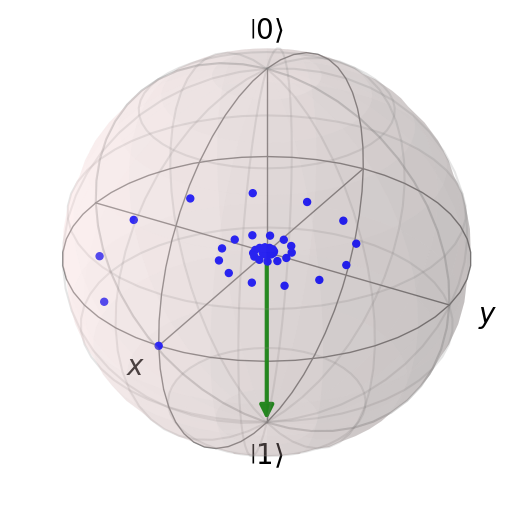

In [25]:
gamma_d = 0.1; gamma_u = 0.0; H = np.array([[0, 0],[0, 1]]); dt = 0.5; t_list = np.arange(0, 60 + dt, dt)

sphere = Bloch()
result = mesolve(Qobj(H),
                 (basis(2,0)+basis(2,1))/np.sqrt(2),
                 t_list,
                 c_ops=[np.sqrt(0.1) * sigmaz()],
                 e_ops=[sigmax(), sigmay(), sigmaz()])
sx, sy, sz = result.expect[0], result.expect[1], result.expect[2]
sphere.add_points([sx, sy, sz])
sphere.add_vectors([0., 0., -1.])
sphere.show()

If you want to produce an animated gif run the following code.

In [ ]:
sphere = Bloch()
for i in range(len(sx)):
    sphere.clear()
    for j in range(i+1):
        sphere.add_points([sx[j], sy[j], sz[j]], alpha=np.exp((j-i)/15))
    sphere.add_vectors([0., 0., -1.])
    sphere.point_color ='b'; sphere.point_marker = 'o'; sphere.point_size = [25]
    sphere.make_sphere()
    sphere.save(name=r'temp_deph_bloch\deph_bloch_{}.png'.format(str(i).zfill(len(str(len(sx))))), dirc=r'temp_deph_bloch')

filenames = [join('temp_deph_bloch', filename) for filename in listdir('temp_deph_bloch') if isfile(join('temp_deph_bloch', filename))]
with imageio.get_writer('Images\Mission beta\movie_deph_bloch.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
shutil.rmtree('temp_deph_bloch')

<div>
<img src="Images\Mission beta\movie_deph_bloch.gif" width="500"/>
</div>

## Stochastic Schrödinger Equation

When the Hilbert space is large, it becomes computationally expensive to evolve the density matrix.

A resource-friendly approach in this case is to **unravel** the Lindblad dynamics in (pure state) trajectories that evolve according to the Stochastic Schrödinger Equation:

$$ d | \psi(t) \rangle = - i H | \psi(t) \rangle dt - \frac{1}{2} \sum_{k} \gamma_{k} L_{k}^{\dagger} L_{k} | \psi(t) \rangle dt - i \sum_{k} \sqrt{\gamma_{k}} L_{k} | \psi(t) \rangle dW_{k}(t)$$

where the second and third terms on the right-hand side resemble a sort of dissipation-fluctuation relation.

$dW_{k}(t)$ is a random process, in our case corresponding to the Wiener process with $\overline{dW_{k}(t)} = 0$ and $\overline{dW_{k}^2(t)}=dt$.

In this vision, every trajectory represents an entry of the **statistical density matrix** which describe the system evolving under the Lindblad equation:
$$
\rho(t) = \lim_{N_\text{traj}\to\infty} \sum_{k=1}^{N_\text{traj}} \frac{1}{N_\text{traj}} | \psi_{k}(t)\rangle \langle \psi_{k}(t) |
$$

In [33]:
dt = 0.001; t_list = np.arange(0, 10 + dt, dt)

trajectories = 1000

gamma_deph = 0.1

H = np.array([[0, 0], [0, 1]], dtype=complex)

L_deph = sigmaz().full()

psi = np.ones((2, trajectories), dtype=complex) / np.sqrt(2)

psi_list = np.zeros((2, trajectories, len(t_list)), dtype=complex)
psi_list[:,:,0] = psi

for m in range(trajectories):
    for i in range(1,len(t_list)):
        dW = np.random.normal(0, 1, 1) * np.sqrt(dt)
        psi_list[:,m,i] = psi_list[:,m,i-1] + (- 1.j * H * dt - 0.5 * gamma_deph * np.conj(L_deph.T) @ L_deph * dt - 1.j * np.sqrt(gamma_deph) * L_deph * dW) @ psi_list[:,m,i-1]

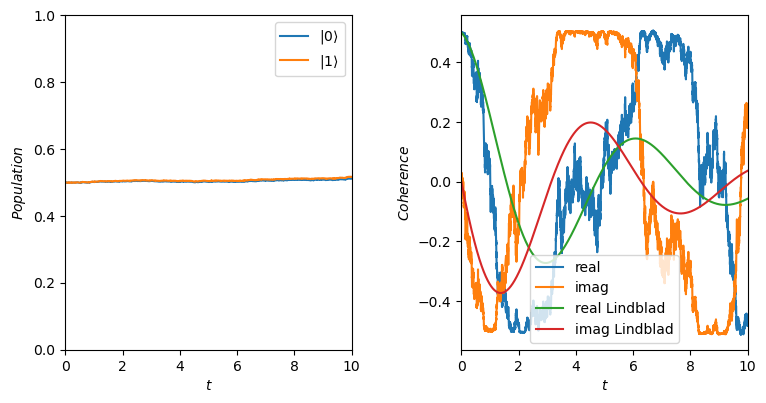

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t_list, np.abs(psi_list[0,0,:])**2, label=r'$| 0 \rangle$')
ax1.plot(t_list, np.abs(psi_list[1,0,:])**2, label=r'$| 1 \rangle$')
ax1.set_xlim(0,t_list[-1]); ax1.set_ylim(0,1); ax1.set_xlabel(r'$t$'); ax1.set_ylabel(r'$Population$'); ax1.legend()

ax2.plot(t_list, np.real(np.conj(psi_list[0,0,:]) *  psi_list[1,0,:]), label='real')
ax2.plot(t_list, np.imag(np.conj(psi_list[0,0,:]) *  psi_list[1,0,:]), label='imag')
ax2.plot(t_list, np.real(Liouville_evo(rho, super_L, t_list)[1, :]), label='real Lindblad')
ax2.plot(t_list, np.imag(Liouville_evo(rho, super_L, t_list)[1, :]), label='imag Lindblad')
ax2.set_xlim(0,t_list[-1]); ax2.set_xlabel(r'$t$'); ax2.set_ylabel(r'$Coherence$'); ax2.legend();
fig.tight_layout(); fig.set_size_inches(8, 4); fig.set_dpi(100)
plt.show()

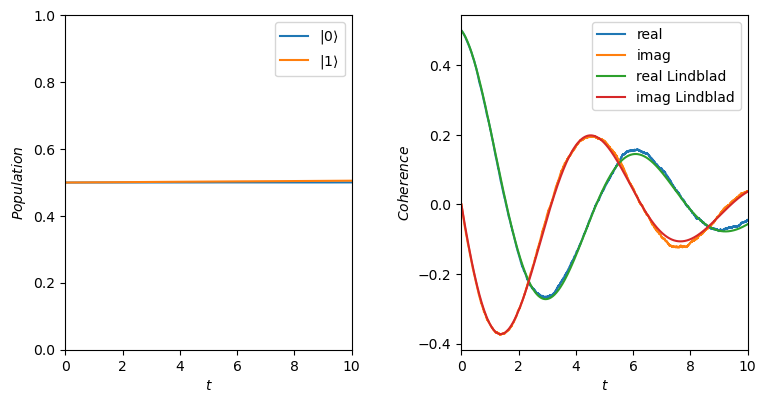

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t_list, np.mean(np.conj(psi_list[0,:,:]) *  psi_list[0,:,:], axis=0), label=r'$| 0 \rangle$')
ax1.plot(t_list, np.mean(np.conj(psi_list[1,:,:]) *  psi_list[1,:,:], axis=0), label=r'$| 1 \rangle$')
ax1.set_xlim(0,t_list[-1]); ax1.set_ylim(0,1); ax1.set_xlabel(r'$t$'); ax1.set_ylabel(r'$Population$'); ax1.legend()

ax2.plot(t_list, np.real(np.mean(np.conj(psi_list[0,:,:]) *  psi_list[1,:,:], axis=0)), label='real')
ax2.plot(t_list, np.imag(np.mean(np.conj(psi_list[0,:,:]) *  psi_list[1,:,:], axis=0)), label='imag')
ax2.plot(t_list, np.real(Liouville_evo(rho, super_L, t_list)[1, :]), label='real Lindblad')
ax2.plot(t_list, np.imag(Liouville_evo(rho, super_L, t_list)[1, :]), label='imag Lindblad')
ax2.set_xlim(0,t_list[-1]); ax2.set_xlabel(r'$t$'); ax2.set_ylabel(r'$Coherence$'); ax2.legend()
fig.tight_layout(); fig.set_size_inches(8, 4); fig.set_dpi(100)
plt.show()